<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2020-1 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones básicas en numpy
* Preprocesamiento y exploración de datos, creación de datos sintéticos
* Regresión Lineal Regularizada: _Ridge_ y _Lasso_
* SVM y Kernels
* Más _Cross Validation_


**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ (en caso de ser repositorio privado, invitar como colaborador al usuario de github "avalderr") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF393/578-2020 Tarea2]
* Fecha de entrega y presentaciones: 31 de Mayo. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en dos partes:

[1.](#primero) Clasificación de datos no-linealmente separables  
[2.](#tercero) Regularización para regresión   

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier análisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.
Si algún modelo se demora demasiado en correr en su máquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, esto puede ser relevante para las máquinas más lentas al momento de realizar exploraciones con _K-folds_ por ejemplo.

<a id="primero"></a>
## 1. Clasificación de datos no-linealmente separables

Algunos modelos de clasificación buscan implicita o explicitamente separar los datos linealmente, es decir ajustar un hiperplano que separe en 2 subespacios el espacio de las variables, separando ambas clases del _target_. Sin embargo en la mayoría de los casos reales esto resulta imposible. Esto no significa que no podamos ajustar modelos con estos datos o buscar transformaciones que nos permitan utilizarlos. 
    
![Alt Text](http://people.cs.uchicago.edu/~dinoj/manifold/swissroll.gif) 

[comment]: <> (Swiss Roll)

En esta primera parte de la tarea crearemos manualmente un set de datos categóricos no linealmente separables. Este se conformará de puntos en $\mathbb{R}^2$, pertenecientes a una de dos categorías etiquetadas 0 o 1, los cuales se encuentran "anidados". Probaremos distintas aproximaciones lineales y no lineales y compararemos sus desempeños.


#### 1.a Creando los datos
La función `do_spiral` retorna un conjunto de puntos etiquetados, donde la etiqueta 0 corresponde a puntos siguiendo la primera mitad de un espiral (con un ruido asociado) y la etiqueta 1 los puntos restantes.

Los parámetros de esta función tienen nombres intencionalmente no descriptivos. Analise la función y comente interpretación puede darle a cada uno de los parámetros con respecto a la influencia que tendrán en el set de datos obtenidos. Si lo estima conveniente, cambie el nombre de los parámetros a nombres más descriptivos.

In [ ]:
from sklearn.utils import check_random_state
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# cf: semi circulo espiral (cf=4 implica 2 circulos espirales)
def do_spiral(n_dots = 1000, ns = 0.05, cf = 4):
    generator = check_random_state(42)
    # Arreglo de theta Ø
    linspace = np.linspace(0, cf*np.pi, int(n_dots))

    # Øcos(Ø)
    circle_x = linspace*np.cos(linspace)
    # Øsin(Ø)
    circle_y = linspace*np.sin(linspace)   

    # Queda entre -1 y 1
    circle_x=circle_x/max(np.max(circle_x),-np.min(circle_x))
    circle_y=circle_y/max(np.max(circle_y),-np.min(circle_y))
        
    # Tabla con los n_dots: | [circle_x] | [circle_y] |
    X = np.vstack((
        np.append(circle_x[0:int(0.5*n_dots)], circle_x[int(0.5*n_dots):]),
        np.append(circle_y[0:int(0.5*n_dots)], circle_y[int(0.5*n_dots):])
    )).T

    # Arreglo de tamaño n_dots, mitad 0s mitad 1s
    y = np.hstack([
        np.zeros(int(n_dots*0.5), dtype=np.intp),
        np.ones(int(n_dots*0.5), dtype=np.intp)
    ])

    # Ruido de anchura de distribución tamaño: ns
    X += generator.normal(scale = ns, size = X.shape)  

    return(train_test_split(X, y, test_size=0.3, random_state=42))

#### 1.b Graficar los datos
Cree una función que grafíque los datos, coloreando distintamente los puntos de cada clase. Utilice esta función para verificar gráficamente lo que propuso en la pregunta anterior variando cada uno de los parámetros de esta función.

A continuación se genera un vector con las combinaciones [(n_dots_1, ns_1, cf_1), (n_dots_2, ns_2, cf_2),..., (n_dots_n, ns_n, cf_n)]

In [ ]:
puntos = np.array([1000,0.05,4])
# Primer gráfico de fábrica

N_graf = 3
cf = 4
ns = 0.05
n_dots = 1000
ptls = list()
for i in range(N_graf):
    cf += (i+1)*int(i%2!=0) + i*int(i%2==0) #i*(int(i%2!=0) + int(i%2==0) + int(i%2!=0)
    ns += i/100
    n_dots += i*1000 + int(i%2!=0)*1000
    puntos = np.vstack((puntos, [n_dots, round(ns, 2), cf]))
puntos = np.asarray(puntos[1:,:])

for i in range(N_graf):
    for j in range(N_graf):
        for k in range(N_graf):
            ptls.append((puntos[i,0], puntos[j, 1], puntos[k, 2]))
ptls

[(1000.0, 0.05, 4.0),
 (1000.0, 0.05, 6.0),
 (1000.0, 0.05, 8.0),
 (1000.0, 0.06, 4.0),
 (1000.0, 0.06, 6.0),
 (1000.0, 0.06, 8.0),
 (1000.0, 0.08, 4.0),
 (1000.0, 0.08, 6.0),
 (1000.0, 0.08, 8.0),
 (3000.0, 0.05, 4.0),
 (3000.0, 0.05, 6.0),
 (3000.0, 0.05, 8.0),
 (3000.0, 0.06, 4.0),
 (3000.0, 0.06, 6.0),
 (3000.0, 0.06, 8.0),
 (3000.0, 0.08, 4.0),
 (3000.0, 0.08, 6.0),
 (3000.0, 0.08, 8.0),
 (5000.0, 0.05, 4.0),
 (5000.0, 0.05, 6.0),
 (5000.0, 0.05, 8.0),
 (5000.0, 0.06, 4.0),
 (5000.0, 0.06, 6.0),
 (5000.0, 0.06, 8.0),
 (5000.0, 0.08, 4.0),
 (5000.0, 0.08, 6.0),
 (5000.0, 0.08, 8.0)]

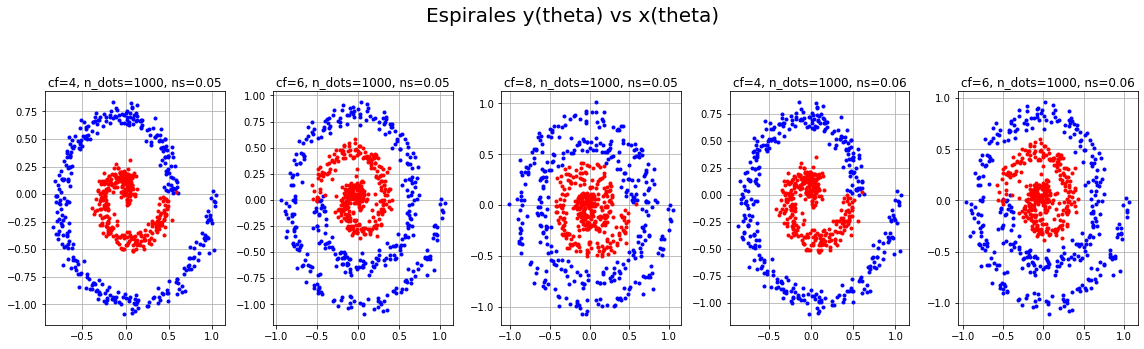

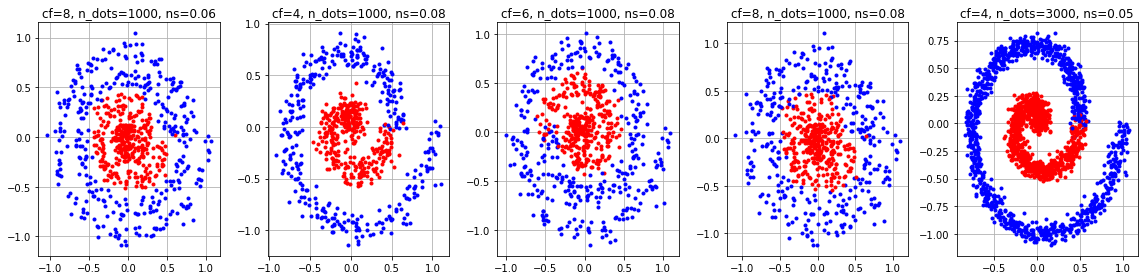

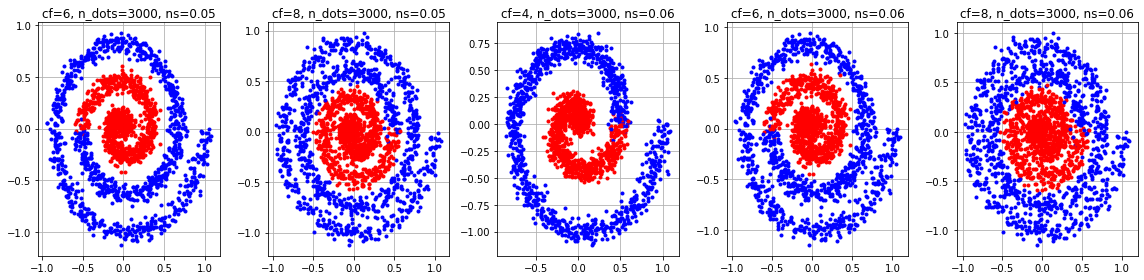

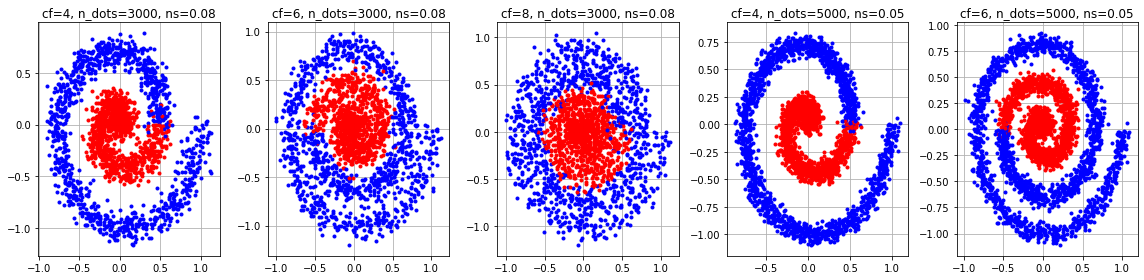

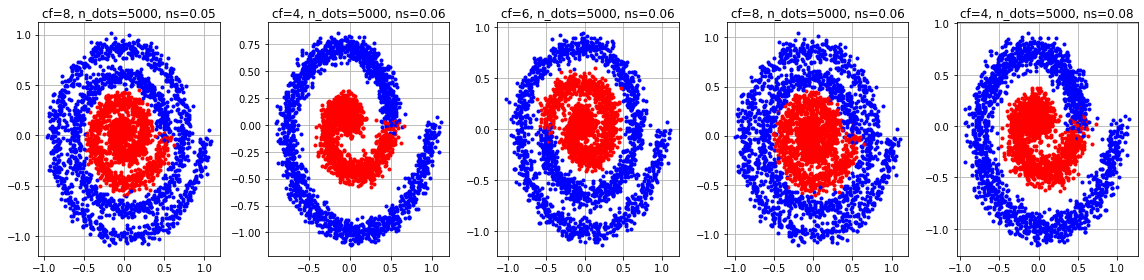

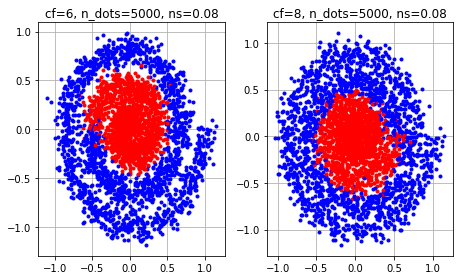

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=[16,4]

plt.suptitle('Espirales y(theta) vs x(theta)',size=20,y=1.2)
k=1

for param in ptls:
    plt.subplot(1,5,k)

    n_dots, ns, cf = param
    n_dots = int(n_dots)
    cf = int(cf)
    plt.title('cf={:d}, n_dots={:d}, ns={:.2f}'.format(cf, n_dots, ns))

    x_tr, x_tst, y_tr, y_tst = do_spiral(n_dots, ns, cf)

    for dot in range(y_tr.shape[0]):
        if y_tr[dot]==0:
            plt.plot(x_tr[dot,0], x_tr[dot,1],'r.')
        if y_tr[dot]==1:
            plt.plot(x_tr[dot,0], x_tr[dot,1],'b.')
    
    plt.tight_layout()
    plt.grid()
    if k==5:
        k=1
        plt.show()
    else:
        k+=1

#### 1.c Regresión Logística

Se realiza una regresión logistica para 5000 puntos generados con los siguientes parámetros:
* `do_spiral(n_dots=5000, ns=0, 6)`
* `do_spiral(n_dots=5000, ns=0.08, 6)`

Grafique los datos que está ajustando y calcule el score del regresor logístico en cada caso. ¿Qué valor entrega el score del regresor logístico? ¿Le parece un buen desempeño para la tarea a realizar?

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

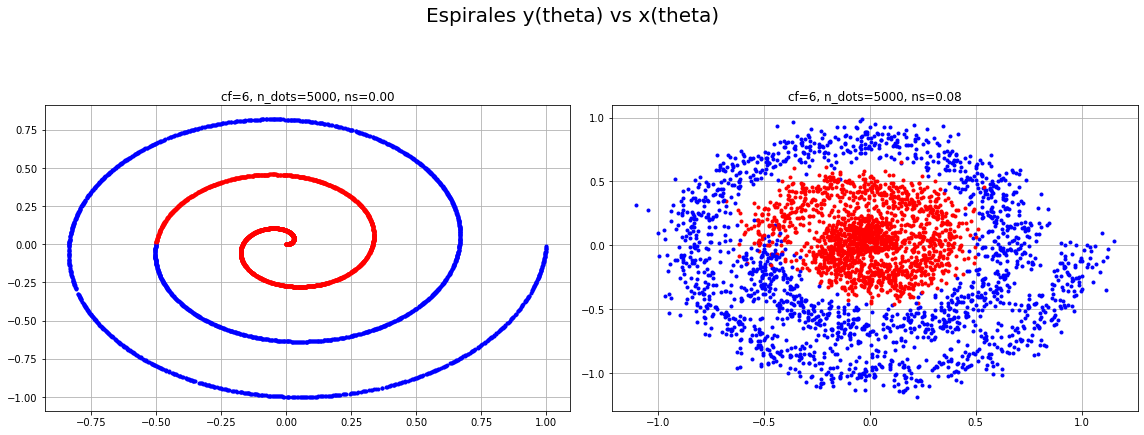

In [ ]:
plt.rcParams["figure.figsize"]=[16,5]
plt.suptitle('Espirales y(theta) vs x(theta)',size=20,y=1.2)

ns_i = [0, 0.08]

for i in range(len(ns_i)):
    plt.subplot(1,2,i+1)    
    n_dots = 5000
    ns = ns_i[i]
    cf = 6
    plt.title('cf={:d}, n_dots={:d}, ns={:.2f}'.format(cf, n_dots, ns))

    if i:
        x_tr2, x_tst2, y_tr2, y_tst2 = do_spiral(n_dots, ns, cf)

        for dot in range(y_tr2.shape[0]):
            if y_tr2[dot]==0:
                plt.plot(x_tr2[dot,0], x_tr2[dot,1],'r.')
            if y_tr2[dot]==1:
                plt.plot(x_tr2[dot,0], x_tr2[dot,1],'b.')

        plt.tight_layout()
        plt.grid()
        plt.show()
        
    
    else:
        x_tr, x_tst, y_tr, y_tst = do_spiral(n_dots, ns, cf)

        for dot in range(y_tr.shape[0]):
            if y_tr[dot]==0:
                plt.plot(x_tr[dot,0], x_tr[dot,1],'r.')
            if y_tr[dot]==1:
                plt.plot(x_tr[dot,0], x_tr[dot,1],'b.')
        plt.tight_layout()
        plt.grid()            

In [53]:
# Para ns=0
log_reg = LogisticRegression()
log_reg.fit(x_tr,y_tr)
ns_0 = log_reg.score(x_tst,y_tst)

# Para ns=0.08
log_reg2 = LogisticRegression()
log_reg2.fit(x_tr2,y_tr2)
ns_008 = log_reg2.score(x_tst2,y_tst2)

# Resultados
print("Score con 0% de ruido = {:.2f}\nScore con 8% de ruido = {:.2f}".format(ns_0, ns_008))

Score con 0% de ruido = 0.68
Score con 8% de ruido = 0.66


Parece el desempeño es muy pobre en ambos casos. Posiblemente porque la frontera de decisión que el modelo genera es lineal, mientras que los datos no lo son.

#### 1.d Graficos
Para entender mejor lo que está ocurriendo con el clasificador en cada uno de los casos, graficaremos los datos clasificados y la frontera de desición ajustada por el modelo. Para esto complete la función siguiente y luego utilicela para ambos modelos y conjuntos de datos ajustados en la pregunta anterior.

¿Qué puede concluír luego de estas visualizaciones? ¿Es posible mejorar el desempeño de algun clasificador lineal sin hacer una transformación de los datos? ¿Qué ocurre con el clasificador si disminuimos el ruido, mejora realmente su desempeño?

In [83]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, tr_tst='test', titulo='Frontera', draw=1, k=None):
              
    if draw == 1:        
        plt.figure(figsize=(12, 8))        
    axis = plt.axes()
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
    Z = Z.reshape(XX.shape) # for consistency
    Zplot = Z > 0.5 # to separate both classes
    plt.pcolormesh(XX, YY, Zplot, cmap='viridis')
    plt.contour(XX, YY, Zplot, alpha=1, colors=["r"], linestyles=["-"], levels=[0.5])
    if tr_tst == 'train':
        # Scatter train points (axis.scatter(. . .)) 
        for dot in range(Y_train.shape[0]):
            if Y_train[dot]==0:
                plt.plot(X_train[dot,0], X_train[dot,1],'r.')
            if Y_train[dot]==1:
                plt.plot(X_train[dot,0], X_train[dot,1],'b.')
    elif tr_tst == 'test':
        # Scatter test points
        for dot in range(Y_test.shape[0]):
            if Y_test[dot]==0:
                plt.plot(X_test[dot,0], X_test[dot,1],'r.')
            if Y_test[dot]==1:
                plt.plot(X_test[dot,0], X_test[dot,1],'b.')        
    plt.title(titulo)  
    if draw == 1:   
        plt.show()

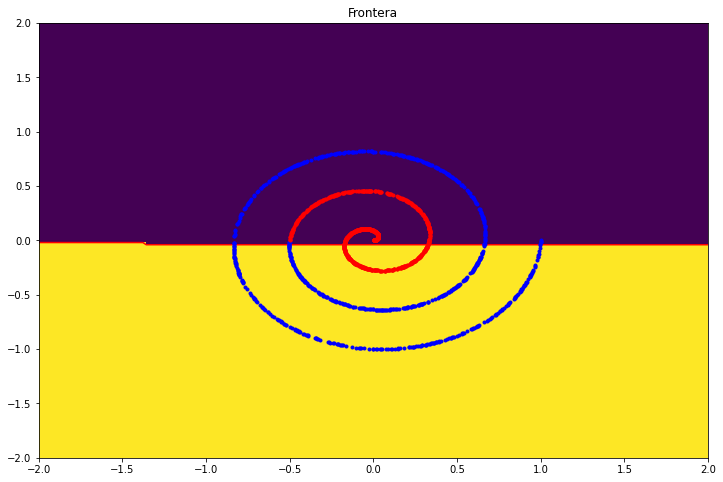

In [78]:
plot_classifier(log_reg, x_tr, y_tr, x_tst, y_tst)

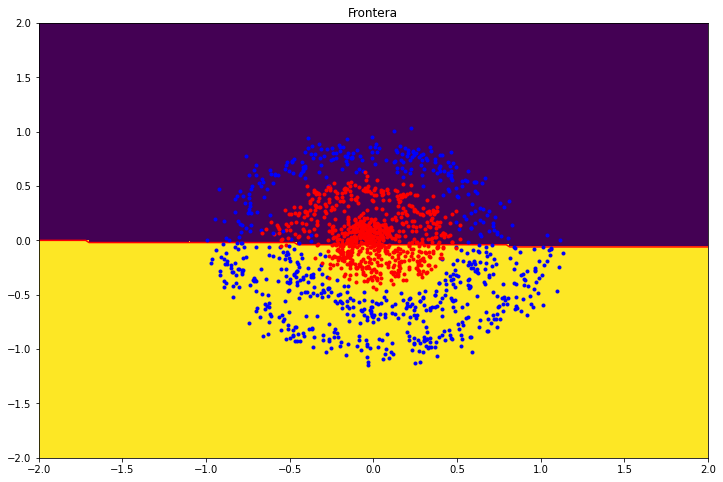

In [79]:
plot_classifier(log_reg2, x_tr2, y_tr2, x_tst2, y_tst2)

Para las siguientes preguntas nos enfocaremos solo en la versión con ruido de los datos, dado que en la práctica es común la existencia de datos con ruido. Probaremos algunos métodos no lineales para ver qué tanto logramos mejorar el desempeño en nuestros datos.

#### 1.e SVM

Entrene un clasificador SVM con los datos con ruido. ¿Qué forma tiene la frontera de desición esta vez?

¿Mejoran los resultados al alejarse de los métodos puramente lineales? Comente sobre el desempeño del modelo y su sensibilidad a los parámetros C y gamma, explorando cómo cambia la frontera de desición al variar estos parámetros.

In [48]:
from sklearn.svm import SVC
import time


#C = Control de clasificacion
#Gamma influencia de una muestra por si sola

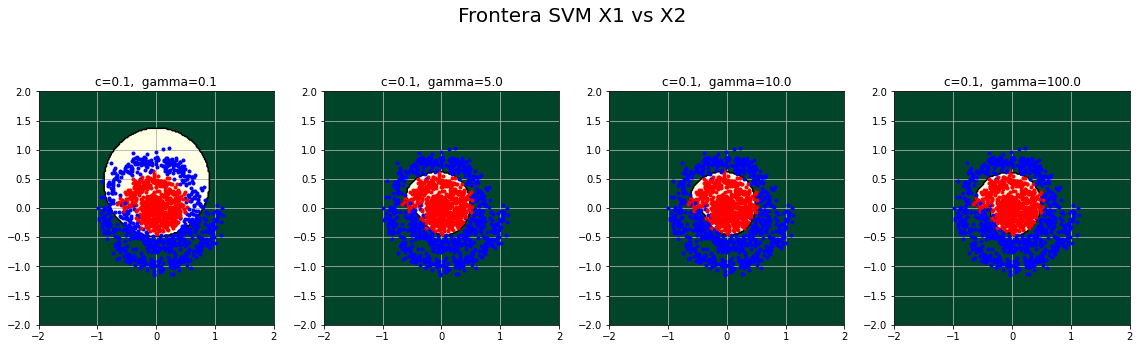

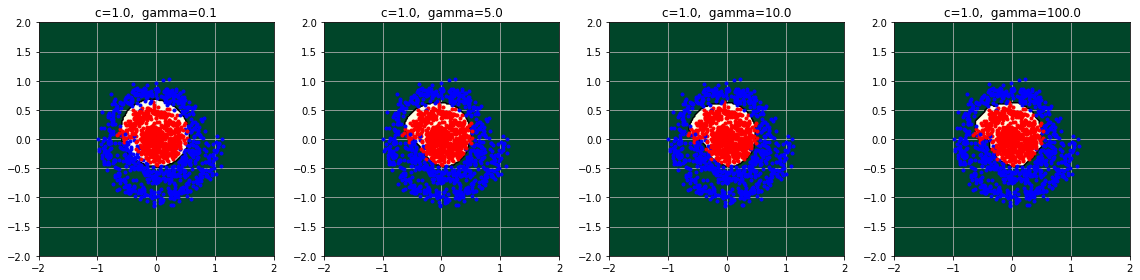

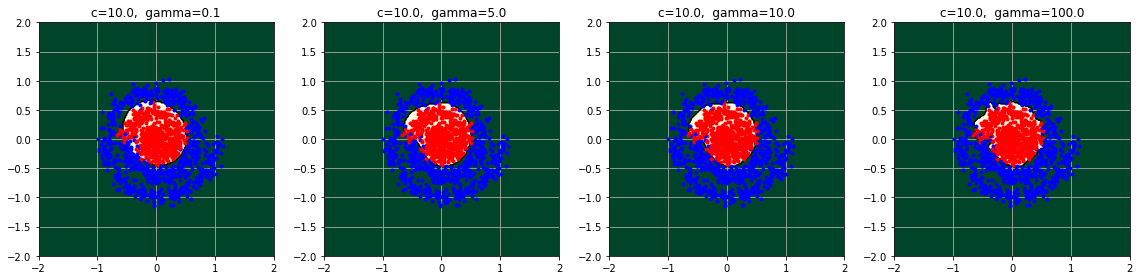

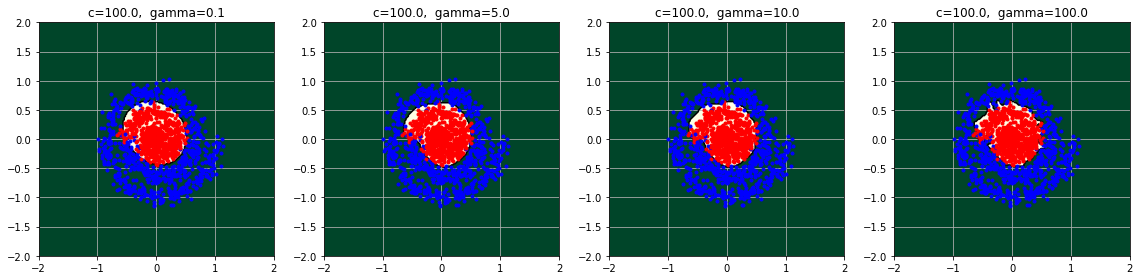

In [ ]:
plt.rcParams["figure.figsize"]=[16,4]
plt.suptitle('Frontera SVM X1 vs X2',size=20,y=1.2)
k=1

cs = [0.1, 1, 10, 100]
gammas = [0.1, 5, 10, 100]

tr_tst='test'

for i in range(len(cs)):
    for j in range(len(cs)):        

        titulo = 'c={:.1f},  gamma={:.1f}'.format(cs[i], gammas[j])
        titulo.replace(".0", " ")

        SV = SVC(C=cs[i], gamma=gammas[j]).fit(x_tr2, y_tr2)        
        
        plt.subplot(1,4,k)                            
        XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
        Z = SV.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
        Z = Z.reshape(XX.shape) # for consistency
        Zplot = Z > 0.5 # to separate both classes
        plt.pcolormesh(XX, YY, Zplot, cmap='YlGn')
        plt.contour(XX, YY, Zplot, alpha=1, colors=["black"], linestyles=["-"], levels=[0.5])
        if tr_tst == 'train':
            # Scatter train points (axis.scatter(. . .)) 
            for dot in range(y_tr2.shape[0]):
                if y_tr2[dot]==0:
                    plt.plot(x_tr2[dot,0], x_tr2[dot,1],'r.')
                if y_tr2[dot]==1:
                    plt.plot(x_tr2[dot,0], x_tr2[dot,1],'b.')
        elif tr_tst == 'test':
            # Scatter test points
            for dot in range(y_tst2.shape[0]):
                if y_tst2[dot]==0:
                    plt.plot(x_tst2[dot,0], x_tst2[dot,1],'r.')
                if y_tst2[dot]==1:
                    plt.plot(x_tst2[dot,0], x_tst2[dot,1],'b.')        
        plt.title(titulo)  
            
        plt.tight_layout()
        plt.grid()
        if k==4:
            k=1
            plt.show()
        else:
            k+=1        

In [49]:
cs = [0.1, 1, 10, 100]
gammas = [0.1, 5, 10, 100]
max_s = -np.inf
best_C = -1
best_gamma = -1
for i in range(len(cs)):
    for j in range(len(cs)):
      
        # Entrenar
        SV = SVC(C=cs[i], gamma=gammas[j]).fit(x_tr2, y_tr2)

        # Validar
        score = SV.score(x_tst2, y_tst2)
        print("Score de SVM con C={} y gamma={}: {:.4f}".format(cs[i], gammas[j], score))
        if score > max_s:
            max_s = score
            best_C = cs[i]
            best_gamma = gammas[j]
print("\nMejor SVM fue con C={}, gamma={} y score={:.4f}".format(best_C, best_gamma, max_s))

Score de SVM con C=0.1 y gamma=0.1: 0.7900
Score de SVM con C=0.1 y gamma=5: 0.9820
Score de SVM con C=0.1 y gamma=10: 0.9813
Score de SVM con C=0.1 y gamma=100: 0.9840
Score de SVM con C=1 y gamma=0.1: 0.9647
Score de SVM con C=1 y gamma=5: 0.9807
Score de SVM con C=1 y gamma=10: 0.9813
Score de SVM con C=1 y gamma=100: 0.9847
Score de SVM con C=10 y gamma=0.1: 0.9727
Score de SVM con C=10 y gamma=5: 0.9820
Score de SVM con C=10 y gamma=10: 0.9820
Score de SVM con C=10 y gamma=100: 0.9833
Score de SVM con C=100 y gamma=0.1: 0.9760
Score de SVM con C=100 y gamma=5: 0.9827
Score de SVM con C=100 y gamma=10: 0.9820
Score de SVM con C=100 y gamma=100: 0.9807

Mejor SVM fue con C=1, gamma=100 y score=0.9847


El modelo mejora considerablemente al aplicar las no linealidades. Con un C=0.1 el desempeño es 0.79, como es inversamente proporcional a la fuerza de regularización entonces se está castigando mucho al modelo. En cambio con un C=100 más alto el castigo es menor. Por otro lado el parámetro gamma nos dice qué tan lejos de la frontera de decisión influye una muestra de entrenamiento. Mientras más alto el valor de gamma, menos influyen los valores más lejanos a la frontera de decisión. Por lo tanto tiene sentido que el mejor resultado haya sido con el gamma=100 más alto, ya que la frontera "natural" entre ambas clases esta claremente definida para muestras con 8% de ruido.

#### 1.f KNN
Pruebe ahora con otro método no linal, K nearest neighbors o KNN. Discuta sus resultados y la frontera de desición que encuentra el modelo.

Realice un Cross Validation sobre el parámetro 'n_neighbors' o 'p' (o ambos usando un mallado) y comente si mejoran significativamente los resultados. Puede apoyarse de los códigos de la tarea 1 para realizar el Cross Validation. ¿Qué representan estos parámetros para el metodo?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss

In [ ]:
neighs = [3, 5, 8, 12, 15, 20]
ps = [1, 2, 3, 4, 5, 6 ]

folds = StratifiedShuffleSplit(n_splits=10)#ShuffleHierach!
score_params = dict()

for n in neighs:
    for p in ps:

        errors_fold = list()
        scores_fold = list()
        for train_index, val_index in folds.split(x_tr2, y_tr2):
            X_train_i, X_val_i = x_tr2[train_index], x_tr2[val_index]
            y_train_i, y_val_i = y_tr2[train_index], y_tr2[val_index]
            KNN = KNeighborsClassifier(n_neighbors=n, p=p)

            # Entrenamiento
            KNN.fit(X_train_i, y_train_i)                                          

            # Score Validacion
            score_i = KNN.score(X_val_i, y_val_i)               
            scores_fold.append(score_i)
        
        # Promediar los scores de los folds para n y p        
        score_params['n: '+str(n)+', p: '+str(p)] = np.mean(scores_fold)

# Mejor modelo
max_score = max(score_params, key=score_params.get)

print('Mejores parametros ->', max_score, 'con score: ' + str(score_params[max_score]))

Mejores parametros -> n: 15, p: 3 con score: 0.986857142857143


Con respecto al metodo anterior no logró mejorarlo, pero la diferencia es muy estrecha. El parámetro n_neighbors significa cuántos vecinos revisar para aprender la clase a la que pertenece cada X. El parámetro p es el grado de la norma. Sin embargo, mientras más alto el grado, la distancia entre un vector y otro es "más" cercana, por lo tanto usar un grado muy alto puede ser engañoso.

#### 1.g
Del mejor modelo obtenido en el punto anterior, grafique los datos de test coloreando de manera difente los puntos mal clasificados por su modelo. ¿Por qué el modelo no logra clasificar bien estos puntos? ¿Qué habría ocurrido si estuvieramos utilizando los datos sin ruido?

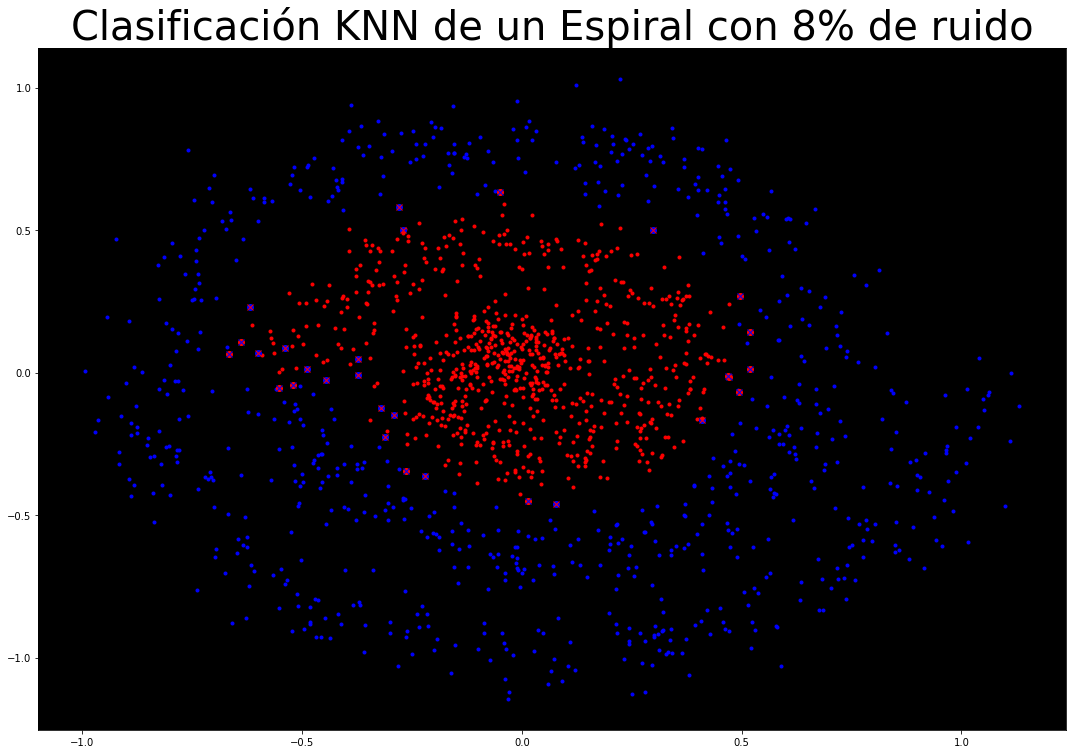

In [ ]:
def plot_KNN(x_tr2, x_tst2, y_tr2, y_tst2, ruido):
    plt.rcParams["figure.figsize"]=[16,5]
    plt.figure(figsize=(15, 10))
    KNN = KNeighborsClassifier(n_neighbors=15, p=3)
    KNN.fit(x_tr2, y_tr2)
    y_pred = KNN.predict(x_tst2)

    for dot in range(y_tst2.shape[0]):
        # Clase verdadera=0
        if y_tst2[dot]==0:

            # Clase predicha correcta
            if y_pred[dot] == 0:
                plt.plot(x_tst2[dot,0], x_tst2[dot,1], 'r.')

            # Clase predicha incorrecta
            elif y_pred[dot] == 1:            
                plt.plot(x_tst2[dot,0], x_tst2[dot,1], 'ro')
                plt.plot(x_tst2[dot,0], x_tst2[dot,1], 'bx')
        # Clase verdadera=1            
        elif y_tst2[dot]==1:

            # Clase predicha correcta
            if y_pred[dot] == 1:
                plt.plot(x_tst2[dot,0], x_tst2[dot,1], 'b.')

            # Clase predicha incorrecta
            elif y_pred[dot] == 0:            
                plt.plot(x_tst2[dot,0], x_tst2[dot,1], 'bo')
                plt.plot(x_tst2[dot,0], x_tst2[dot,1], 'rx')

    ax = plt.gca()
    ax.set_facecolor('k')
    plt.tight_layout()
    plt.title('Clasificación KNN de un Espiral con {}% de ruido'.format(ruido), {'fontsize': 40})
    plt.show()
plot_KNN(x_tr2, x_tst2, y_tr2, y_tst2, 8)            

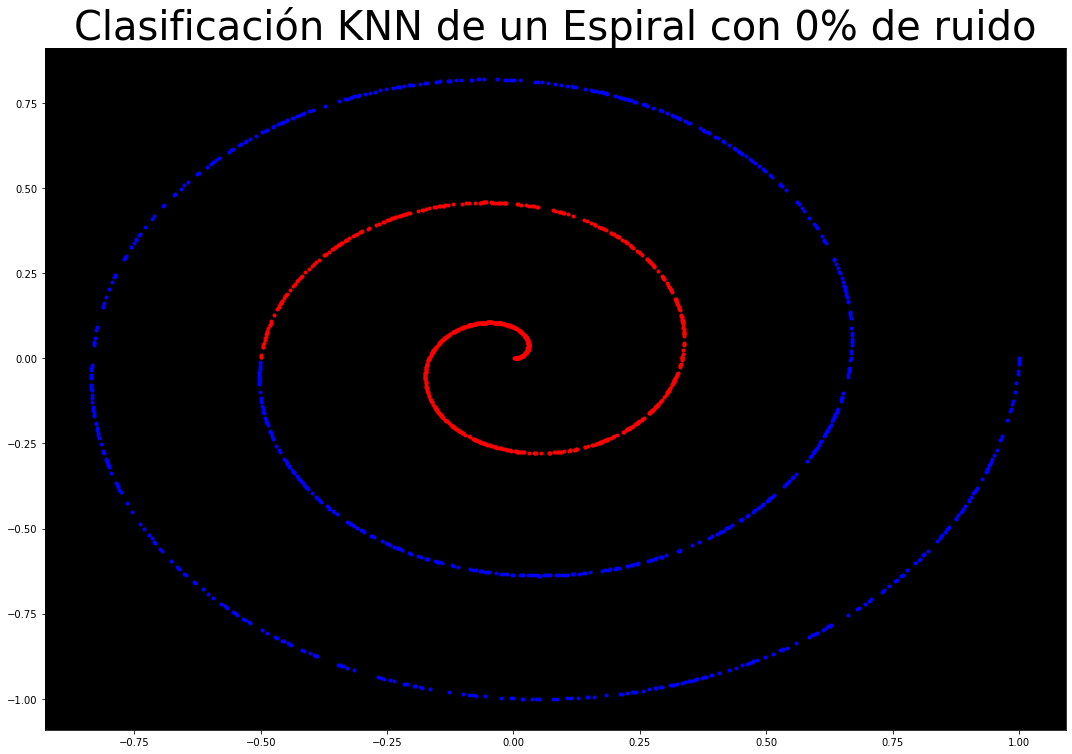

In [ ]:
plot_KNN(x_tr, x_tst, y_tr, y_tst, 0)

¿Por qué el modelo no logra clasificar bien estos puntos? Por que al ser puntos cercanos a la frontera pueden haber más vecinos de la clase incorrecta. 

¿Qué habría ocurrido si estuvieramos utilizando los datos sin ruido? Si no tuvieran ruido, no habría error ya que las fronteras de cada clase estarían separadas. Los puntos que estan cerca del cambio de clases tienen más vecinos de su misma clases que de la clase contraria.



#### 1.h Metodo Kernel
Utilizaremos Kernel Gaussiano para preprocesar los datos, pasando implícitamente por un espacio áltamente dimensional (más específicamente por un manifold de un espacio infinito dimensional), obteniendo una representación lo más linealmente separable posible.

Ajuste el kernel y transforme los datos. Grafique los puntos transformados y comente qué realiza el modelo. Varíe luego el valor de gamma para tratar de entender qué influencia tiene sobre la separabilidad de los puntos transformados. ¿Le parece un buen método para este problema?

Usando algún valor de gamma que le parezca adecuado, ajuste un modelo de regresión logística sobre los datos transformados. Mejora el desempeño del modelo respecto a la versión original? ¿Se logra aumentar la separabilidad lineal de los datos efectivamente? Apoyese de gráficos y métricas adecuados. Utilice una matriz de confusión para este análisis

In [ ]:
from sklearn.decomposition import KernelPCA

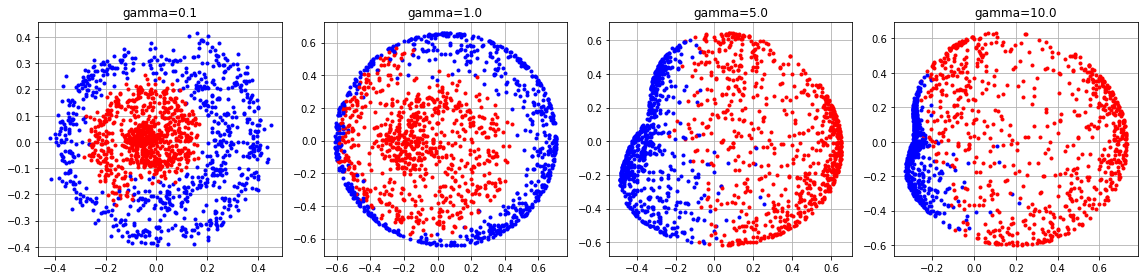

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


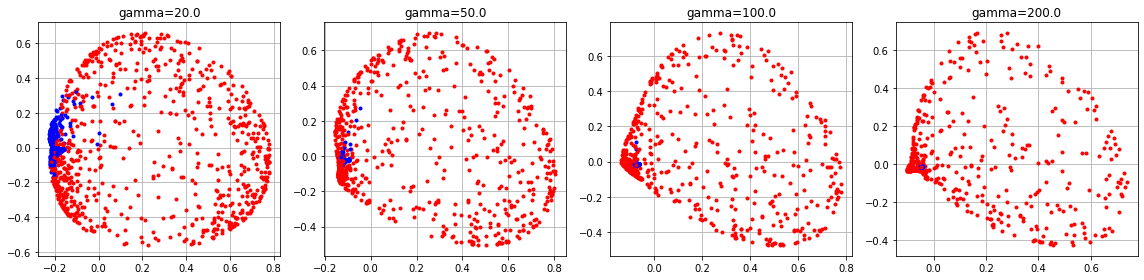

In [ ]:
plt.rcParams["figure.figsize"]=[16,4]
#plt.suptitle('Frontera SVM X1 vs X2',size=20,y=1.2)
k=1

gammas = [0.1, 1, 5, 10, 20, 50, 100, 200]

tr_tst='test'


for j in range(len(gammas)):        

    titulo = 'gamma={:.1f}'.format(gammas[j])
    titulo.replace(".0", " ")

    ker = KernelPCA(2,kernel='rbf',gamma=gammas[j])
    ker.fit(x_tr2)
    X_ker_train = ker.transform(x_tr2)
    X_test_transformed = ker.transform(x_tst2)

    plt.subplot(1,4,k)                               
    if tr_tst == 'train':
        # Scatter train points (axis.scatter(. . .)) 
        for dot in range(y_tr2.shape[0]):
            if y_tr2[dot]==0:
                plt.plot(X_ker_train[dot,0], X_ker_train[dot,1],'r.')
            if y_tr2[dot]==1:
                plt.plot(X_ker_train[dot,0], X_ker_train[dot,1],'b.')
    elif tr_tst == 'test':
        # Scatter test points
        for dot in range(y_tst2.shape[0]):
            if y_tst2[dot]==0:
                plt.plot(X_test_transformed[dot,0], X_test_transformed[dot,1],'r.')
            if y_tst2[dot]==1:
                plt.plot(X_test_transformed[dot,0], X_test_transformed[dot,1],'b.')        
    plt.title(titulo)  
        
    plt.tight_layout()
    plt.grid()
    if k==4:
        k=1
        plt.show()
    else:
        k+=1        

Se observa que mientras más grande gamma, más se concentran los puntos. Con Gamma=5 o Gamma=10 se podría aplicar algún algoritmo con frontera de decision lineal.

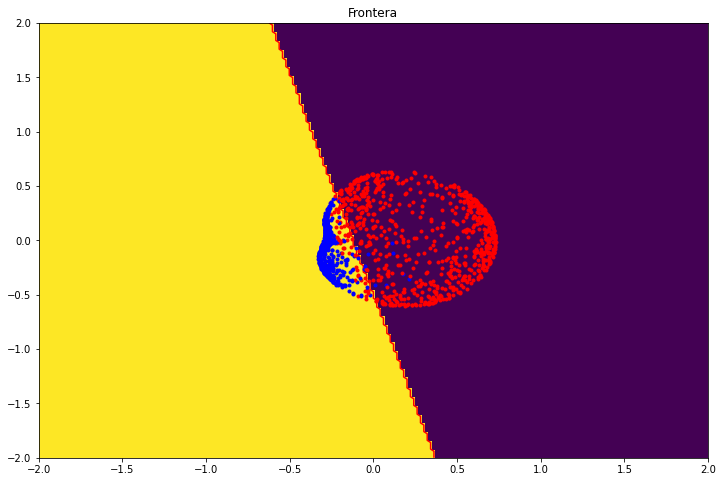

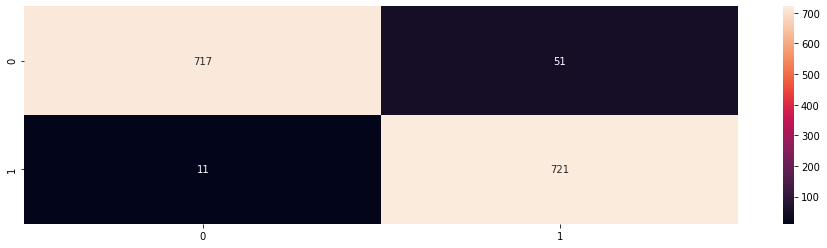


Score Kernel PCA:  0.9586666666666667


In [84]:
import seaborn as sns
from sklearn import metrics

# Kernel escogido
ker = KernelPCA(2,kernel='rbf',gamma=10)
ker.fit(x_tr2)
X_ker_train = ker.transform(x_tr2)
X_test_transformed = ker.transform(x_tst2)

# Regresion logistica
log_reg = LogisticRegression()
log_reg.fit(X_ker_train,y_tr2)

plot_classifier(log_reg, X_ker_train, y_tr2, X_test_transformed, y_tst2)

confusion_matrix = metrics.confusion_matrix(y_tst2, log_reg.predict(X_test_transformed))
sns.heatmap(confusion_matrix,annot=True,fmt='d')
plt.show()
print('\nScore Kernel PCA: ', log_reg.score(X_test_transformed, y_tst2))

¿Se logra aumentar la separabilidad lineal de los datos efectivamente? Si, al observar el gráfico de Frontera se puede apreciar que con la transformación los datos ahora son linealmente separables. El desempeño subió de un 66% de accuracy a un 95%.

#### 1.i Manualmente
Como nosotros conocemos cómo se generaron los datos tenemos una ventaja sobre los modelos. Genere una transformación de los datos que estime conveniente para obtener datos linealmente separables. Puede aumentar o disminuir la dimensión a gusto, por ejemplo puede realizar algo del estilo $(x,y)\longrightarrow (x+y)$, ó $(x,y)\longrightarrow (x,y,x+y,x-y)$. Apoyese de las carácteristicas geométricas del conjunto de datos y justifique sus elecciónes con gráficos adecuados.

Luego entrene un regresor logístico sobre sus datos transformados y comente sobre la utilidad de conocer cómo se generaron los datos. Grafique los datos transformados o alguna proyección de ellos junto con la frontera de desición y comente sobre lo que realiza su transformación.

Se elige la transformación $$(x, y) \rightarrow (x, y, x^2 + y^2)$$

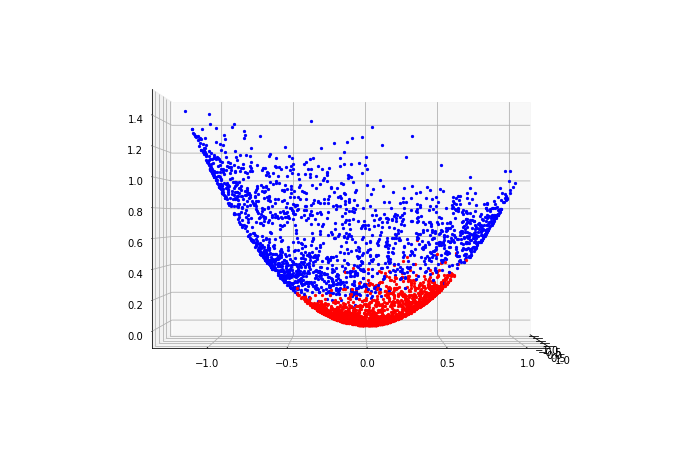

In [128]:
from mpl_toolkits.mplot3d import Axes3D

X_cono_train = np.concatenate((x_tr2, (x_tr2[:,0]**2 + x_tr2[:,1]**2).reshape(-1,1)), axis=1)
X_cono_test = np.concatenate((x_tst2, (x_tst2[:,0]**2 + x_tst2[:,1]**2).reshape(-1,1)), axis=1)
        
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for dot in range(y_tr2.shape[0]):
    if y_tr2[dot]==0:        
        ax.scatter(X_cono_train[dot,0], X_cono_train[dot,1], X_cono_train[dot,2], c='r', marker='.')        
    if y_tr2[dot]==1:
        ax.scatter(X_cono_train[dot,0], X_cono_train[dot,1], X_cono_train[dot,2], c='b', marker='.')

# Cambio de angulo
ax.view_init(0, 0)
plt.show()


Score Transformación manual:  0.972


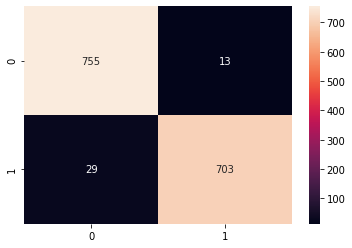

In [130]:
# Regresion logistica
log_reg = LogisticRegression()
log_reg.fit(X_cono_train,y_tr2)

# Matriz de confusion
confusion_matrix = metrics.confusion_matrix(y_tst2, log_reg.predict(X_cono_test))
sns.heatmap(confusion_matrix,annot=True,fmt='d')

print('\nScore Transformación manual: ', log_reg.score(X_cono_test, y_tst2))

Como se muestra en la matriz de confusión el desempeño mejora cuando se agrega esta 3era dimensión, esto debido a que la clase "roja" esta en el centro y por lo tanto estos valores más cercanos a 0 en el nuevo eje z se quedan abajo, y los valores mas alejados (clase azul) quedarán arriba, lo que hará el problema linealmente separable.

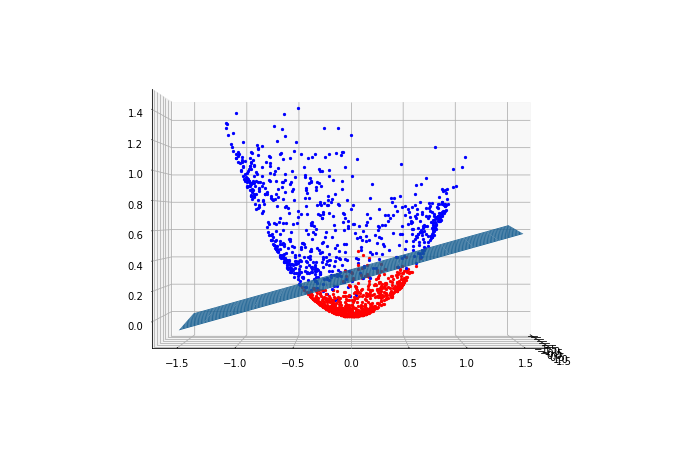

In [148]:
# A continuación se grafica el cono 3d con el plano separador por la regresión logística
        
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for dot in range(y_tst2.shape[0]):
    if y_tst2[dot]==0:        
        ax.scatter(X_cono_test[dot,0], X_cono_test[dot,1], X_cono_test[dot,2], c='r', marker='.')        
    if y_tst2[dot]==1:
        ax.scatter(X_cono_test[dot,0], X_cono_test[dot,1], X_cono_test[dot,2], c='b', marker='.')

#ax.hold(True)

coef = log_reg.coef_[0]
# ax + by + cz - d = 0
a = coef[0]
b = coef[1]
c = coef[2]
d = -log_reg.intercept_[0]

x = np.linspace(-1.5, 1.5, 15)
y = np.linspace(-1.5, 1.5, 15)

X,Y = np.meshgrid(x,y)
Z = (d - a*X - b*Y) / c

ax.plot_surface( X, Y, Z)


# Cambio de angulo
ax.view_init(0, 0)
plt.show()

 Conocer cómo se generaron los datos en este caso es fundamental, ya que de lo contrario no hubiera sido posible sospechar que aumentar la dimensionalidad a 3d con $z=x²+y²$ sería una buena transformación.

<a id="tercero"></a>
## 2. Regularización para regresión. 

Un problema que podemos encontrar transversalmente a todos los modelos es el problema del _overfitting_. Este problema consiste en un modelo que aprende demasiado bien los datos de ejemplo o entrenamiento, al punto que al momento de ver ejemplos desconocidos o de validación, baja su desempeño respecto a un modelo "menos entrenado". En algunos casos podriamos decir que el modelo "aprende de memoria" los ejemplos, en vez de intentar obtener información generalizable a partir de su entrenamiento. Para el caso de la regresión, una de las aproximaciones más comunes para tratar de mitigar este efecto es el de la regularización. Agregando una penalización a la norma de los parametros de la regresión podemos restringir la eficiencia del modelo al momento de aprender los datos de entrenamiento, incluso forzando dependiendo de la intensidad de la regularización que algunos parametros se vuelvan cero. 

<img src="https://openweathermap.org/themes/openweathermap/assets/img/new-history-forecast-bulk.png"  style="height:9cm;"  />

En esta pregunta utilizaremos nuevamente la base de datos de climática disponible en https://www.kaggle.com/budincsevity/szeged-weather para predecir la humedad dadas distintas características ambientales y temporales. Utilizaremos estos datos para enfocarnos en la regularización para regresión. Exploraremos como varian los distintos errores de predicción y analizar cómo cambian los valores de los parámetros ajustados por el modelo para distintos valores del coeficiente de regularización, para tratar de entender qué ocurre con las distintas regularizaciones y sus diferencias. 

**Si experimenta problemas de memoria con el dataset utilizado siéntase libre de acortar el número de data en un 50%**

#### 2.a Carga y preprocesamiento.
**i)** Comente brevemente el contenido de cada una de las columnas del dataset.

El dataset consta de 12 columnas, en la primera se encuentra la hora y día de la medición, luego continúan carácterísticas ambientales del clima actual, estas son clima presente, el tipo de precipitación, temperatura y la temperatura aparente, humedad, velocidad del viento, comportamiento del viento, visibilidad, pesión y finalmente el resumen del día. Este último dato debe tomarse como el target de la medición.

La mayoría de los datos son numéricos y exactos, excepto por el clima presente y el tipo de precipitación que son escritos.

**ii)** Cargue los datos, inicialmente transformaremos la primera columna con el fin de obtener una representación bi-dimensional del mes y hora de cada fecha. A continuación se muestra el proceso para obtener una representación bi-dimensional de la hora, repita el proceso para obtener la representación bivariada del mes. Luego agregue las 4 variables al dataset original en reemplazo de la columna original "Formatted Dates". Grafique ambas variables bi-dimensionales de manera separada y comente

In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("weatherHistory.csv")
column_names=data.columns
dates=np.asarray(data[column_names[0]].str.split(n=1,pat="+",expand=True)[0])
hours=np.asarray(pd.to_datetime(dates).hour)
months=np.asarray(pd.to_datetime(dates).month)
hour1=np.sin(2*pi*((hours/24)-1))
hour2=np.cos(2*pi*((hours/24)-1))
month1=np.sin(2*pi*((months/12)-1))
month2=np.cos(2*pi*((months/12)-1))

In [3]:
data=data.drop([column_names[0]],axis=1)
data["Hour_1"]=hour1
data["Hour_2"]=hour2
data["Month_1"]=month1
data["Month_2"]=month2

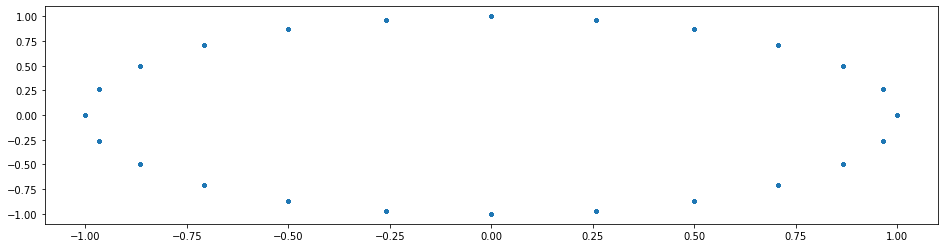

In [4]:
plt.rcParams["figure.figsize"]=[16,4]
plt.plot(hour1,hour2,".");

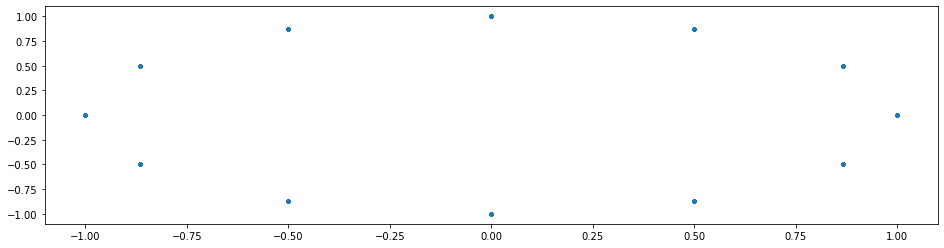

In [5]:
plt.rcParams["figure.figsize"]=[16,4]
plt.plot(month1,month2,".");






Al graficar ambos datos, es posible notar como ambas completan el círculo, teniendo una totalidad de 24 y 12 puntos respectivamente, eso indica que tenmos datos de todas las horas del día y de todos los meses del año.

**iii)** Borre las columnas categóricas Summary y Daily Summary. Si bien pudiesen usarse con pd.get_dummies, el número de columnas aumentaría en gran medida dificultando el análisis deseado. Tan solo transforme con pd.get_dummies la columna "Precip Type" 

In [6]:
data=data.drop(["Daily Summary"],axis=1)
data=data.drop(["Summary"],axis=1)
Dum=pd.get_dummies(data["Precip Type"])
data=data.drop(["Precip Type"],axis=1)
data[Dum.columns]=Dum

**iv)** Separe el dataset, utilize 0.7 de los datos como training set, 0.2 como validation set y 0.1 como test set, verifique el tamaño de cada conjunto. Utilice la columna humidity como target. 

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
Y=data["Humidity"]
X=data.drop(["Humidity"],axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [9]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=(2/3))

In [10]:
print(round(len(x_train)/len(data),2), round(len(y_train)/len(data),2), 
      round(len(x_test)/len(data),2), round(len(y_test)/len(data),2), 
      round(len(x_val)/len(data),2), round(len(y_val)/len(data),2))

0.7 0.7 0.1 0.1 0.2 0.2


**v)** Estandarice el resto de variables continuas.

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
column_names=X.columns
column_names = column_names.drop('Loud Cover','Wind Bearing (degrees)')

In [13]:
scaler = StandardScaler()
scaler.fit(data[column_names[:5]])

StandardScaler()

In [14]:
aux1 = pd.DataFrame(scaler.transform(x_train[column_names[:5]]),columns=column_names[:5])
x_train = x_train.drop(column_names[:5],axis=1).reset_index()
x_train[column_names[:5]] = aux1
x_train = x_train.drop('index',axis=1)

aux2 = pd.DataFrame(scaler.transform(x_test[column_names[:5]]),columns=column_names[:5])
x_test = x_test.drop(column_names[:5],axis=1).reset_index()
x_test[column_names[:5]] = aux2
x_test = x_test.drop('index',axis=1)

aux3 = pd.DataFrame(scaler.transform(x_val[column_names[:5]]),columns=column_names[:5])
x_val = x_val.drop(column_names[:5],axis=1).reset_index()
x_val[column_names[:5]] = aux3
x_val = x_val.drop('index',axis=1)

In [15]:
Y = np.array(Y).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

In [16]:
y_scaler = StandardScaler()
y_scaler.fit(Y)
y_train = pd.DataFrame(y_scaler.transform(y_train))
y_test = pd.DataFrame(y_scaler.transform(y_test))
y_val = pd.DataFrame(y_scaler.transform(y_val))

#### 2.b Modelo sin regularización
Entrene un modelo de regresión lineal no regularizado con los datos preprocesados. Calcule el error cuadrático medio (MSE) del modelo para el conjunto de validación y el de entrenamiento.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [18]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [19]:
y_pred_train = reg.predict(x_train)
mse_train = mean_squared_error(y_train,y_pred_train)

y_pred_val = reg.predict(x_val)
mse_val = mean_squared_error(y_val,y_pred_val)

In [20]:
print("Error cuadrático medio de entrenamiento:",mse_train)
print("Error cuadrático medio de validación:",mse_val)

Error cuadrático medio de entrenamiento: 0.3568576986670639
Error cuadrático medio de validación: 0.3603076622446187


#### 2.c Regularización
Discuta que busca realizar (en términos del ajuste de los parámetros del modelo de regresión lineal) la regularización de Lasso. ¿Por qué se habla de penalización en norma $L^1$? Apóyese de ecuaciones. ¿Qué importancia tiene el parámetro de regularización $\lambda$?

¿Qué diferencia hay entre Lasso y Ridge?

La regularización Lasso busca disminuir los atributos de entrada, esto para minimizar el tamaño de esta. Esto lo hace revisando las correlaciones entre los atributos.

Se llama penalización en norma $L^1$, debido a que su fórmula es de grado 1, es decir lineal, como se puede apreciar:

$C = \sum_{i=1}^{I}{|\beta_j|}$

La importancia de $\lambda$ radica en la consideración de un termino regularizador al momento de minimizar el riesgo.

La diferencia que tiene Lasso a Ridge va en que Ridge se dedica a hacer los coeficientes más pequeños, mientras que Lasso hace algunos coeficientes 0 dependiendo de la correlación que existan entre estos.

#### 2.d Influencia sobre el error
Grafique como varia el error de entrenamiento y el error de validación a medida se cambia el valor del parámetro $\lambda$. Para esto debe entrenar un modelo para cada uno de los parámetros que considerará en el gráfico y calcular el MSE para ambos sets. Comente sobre lo que ve en el gráfico y si lo encuentra pertinente puede calcular en más detalle alguna zona que le parezca interesante. Es conveniente entrenar primero unos cuantos modelos con valores de $\lambda$ escogidos manualmente para saber mejor en que intervalo resulta pertinente calcular estos valores (para Ridge se necesitan valores más altos en este caso para ver la influencia sobre el error).

Note que el parámetro $\lambda$ es sensible a la escala de los datos, por lo cual deberá estudiar valores distintos dependiendo de si estandarizó el target o no.

In [21]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

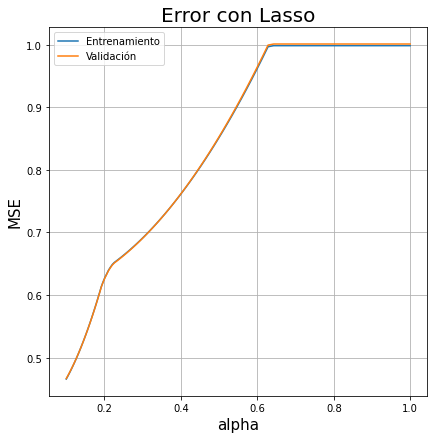

In [22]:
# LASSO
MSE_list_train = []
MSE_list_val = []

space = np.logspace(-1,0,100)

for lambd in space:
    model = Lasso(alpha=lambd)
    model.fit(x_train,y_train)
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    MSE_list_train.append(mean_squared_error(y_train,y_pred_train))
    MSE_list_val.append(mean_squared_error(y_val,y_pred_val))

fig = plt.figure(figsize = (80,80))
ax = fig.add_subplot(10,10,10) 
ax.set_xlabel('alpha', fontsize = 15)
ax.set_ylabel('MSE', fontsize = 15)
ax.set_title('Error con Lasso', fontsize = 20)

ax.plot( space, MSE_list_train, label = "Entrenamiento")
ax.plot( space, MSE_list_val, label = "Validación")
ax.legend()
plt.grid();

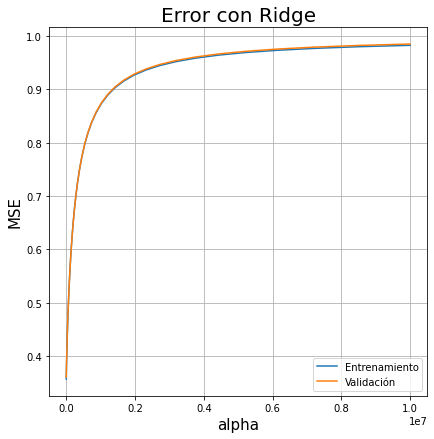

In [23]:
# RIDGE
MSE_list_train = []
MSE_list_val = []
space = np.logspace(-1e-3,7,100)
for lambd in space:
    model = Ridge(alpha=lambd)
    model.fit(x_train,y_train)
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    MSE_list_train.append(mean_squared_error(y_train,y_pred_train))
    MSE_list_val.append(mean_squared_error(y_val,y_pred_val))
    
fig = plt.figure(figsize = (80,80))
ax = fig.add_subplot(10,10,10) 
ax.set_xlabel('alpha', fontsize = 15)
ax.set_ylabel('MSE', fontsize = 15)
ax.set_title('Error con Ridge', fontsize = 20)

ax.plot( space, MSE_list_train, label = "Entrenamiento")
ax.plot( space, MSE_list_val, label = "Validación")
ax.legend()
plt.grid();

En ambos gráficos, el set de entrenamiento con el de validación van juntos, por lo que se estima que no hay sobre ajuste. 
Por otro lado, en cuanto al error, Lasso aumenta el error mucho antes que Ridge, habiendo una gran diferencia. Esto debido a que la penalización en Ridge es mucho mas blanda que en Lasso.

#### 2.e Influencia sobre los coeficientes
Grafique ahora como se comporta el valor de los coeficientes del modelo lineal en el modelo entrenado a medida crece $\lambda$, tanto para Lasso como para Ridge. Para esto entrene un modelo para cada valor de $\lambda$ y guarde sus coeficientes, como propone el princio de código a continuación. Debe explorar valores de $\lambda$ donde todos los coeficientes sean no nulos hasta valores donde todos los coeficientes se anulan.

¿Qué diferencias ve entre Ridge y Lasso? ¿Coincide este comportamiento con lo que esperaría teóricamente de cada uno de los modelos?

¿Podemos utilizar estos gráficos para discutir sobre la cantidad de información que entrega cada uno de los atributos para predecir el target? ¿Cual de ambos (Ridge o Lasso) le parece mejor para este tipo de discusión? Compare lo que muestran estos gráficos con la correlación entre las variables usadas para la predicción y target. Discuta.

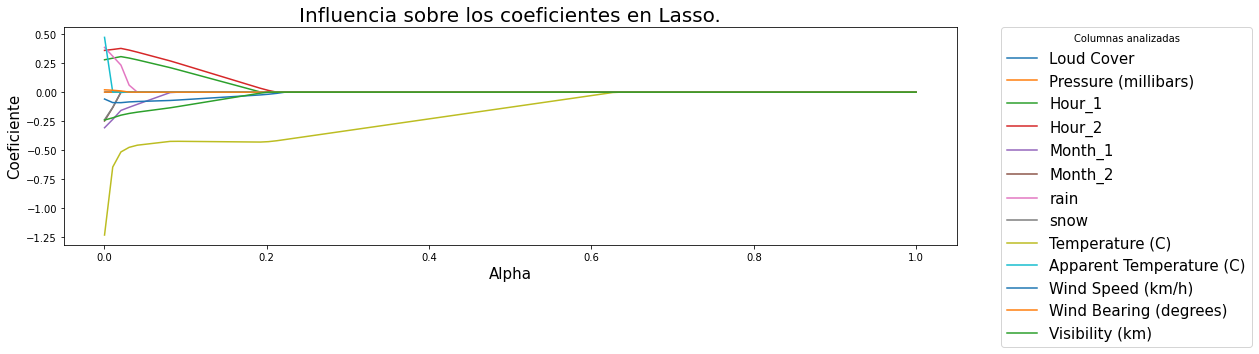

In [24]:
space = np.linspace(0.0001,1,100) 

coefs = []
x_cols = x_train.columns
for l in space:
    model = Lasso(alpha = l)
    model.fit(x_train[x_cols],y_train)
    coefs.append(model.coef_)

for y_arr, label in zip(np.squeeze(coefs).T, x_cols):
    plt.plot(space, y_arr, label=label)
    plt.legend(title='Columnas analizadas', bbox_to_anchor=(1.05, 1)
               , loc='upper left', borderaxespad=0., prop={'size': 15})
    plt.xlabel('Alpha', fontsize = 15)
    plt.ylabel('Coeficiente', fontsize = 15)
    plt.title('Influencia sobre los coeficientes en Lasso.', fontsize = 20)

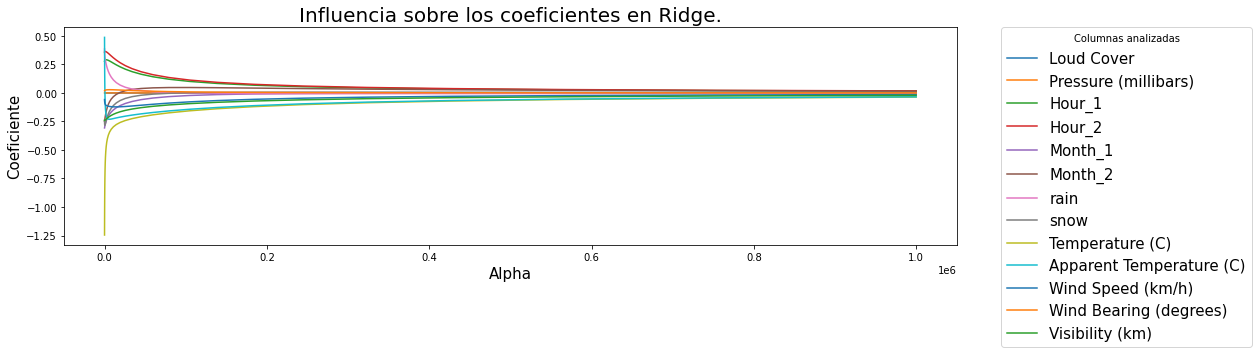

In [36]:
space = np.logspace(0,6,50)

coefs = []
for l in space:
    model = Ridge(alpha = l)
    model.fit(x_train[x_cols],y_train)
    coefs.append(model.coef_)

for y_arr, label in zip(np.squeeze(coefs).T, x_cols):
    plt.plot(space, y_arr, label=label)
    plt.legend(title='Columnas analizadas', bbox_to_anchor=(1.05, 1)
               , loc='upper left', borderaxespad=0., prop={'size': 15})
    plt.xlabel('Alpha', fontsize = 15)
    plt.ylabel('Coeficiente', fontsize = 15)
    plt.title('Influencia sobre los coeficientes en Ridge.', fontsize = 20)

En ridge el decremento es más suave en comparación a Lasso, además de ocurrir mucho despues. Esto tiene mucho que ver con la teoría, dada la penalización que ocurre en cada uno.

En cuanto a los atributos, se puede mencionar que los coeficientes que contienen una pendiente mayor, serán más independientes, por lo cual no afectarán a la medición y dado que son más penalizados.

Por último, Lasso parece ser mejor en este último aspecto, debido a que se distinge mejor la independencia de las variables.

#### 2.f K-_fold_ sobre $\lambda$
Realice 5-fold o 10-fold sobre el parámetro de regularización $\lambda$, ya sea para Lasso o Ridge. Explore a lo menos 20 valores distintos de $\lambda$ en un intervalo relevante luego de lo aprendido en las preguntas anteriores. Utilice MSE como el error a minimizar.

Compare el error de entrenamiento y de validación para este modelo respecto al modelo lineal sin regularización entrenado inicialmente. ¿En su opinión se alcanza a apreciar el fenomeno de overfitting para este conjunto de datos y el modelo logístico?

In [26]:
from sklearn.model_selection import KFold

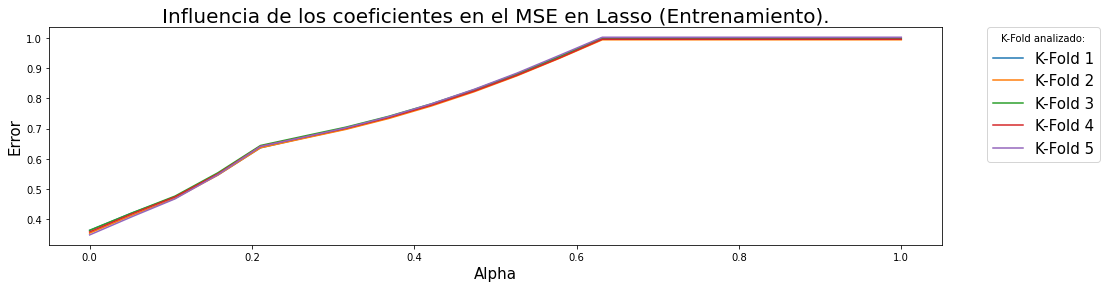

In [27]:
space = np.linspace(0.0001,1,20) 

kf = KFold(n_splits=5, shuffle=True, random_state=2)

MSE = []
for l in space:
    model = Lasso(alpha = l)
    mse = []
    for t,v in kf.split(x_train):
        x_t, x_v = x_train.loc[t], x_train.loc[v]
        y_t, y_v = y_train.loc[t], y_train.loc[v]
        model.fit(x_t,y_t)
        y_pred = model.predict(x_v)
        mse.append(mean_squared_error(y_v,y_pred))
    MSE.append(mse)
    
ind = 1
for y_arr in np.squeeze(MSE).T:
    plt.plot(space, y_arr, label='K-Fold '+str(ind))
    plt.legend(title='K-Fold analizado:', bbox_to_anchor=(1.05, 1)
               , loc='upper left', borderaxespad=0., prop={'size': 15})
    plt.xlabel('Alpha', fontsize = 15)
    plt.ylabel('Error', fontsize = 15)
    plt.title('Influencia de los coeficientes en el MSE en Lasso (Entrenamiento).', fontsize = 20)
    ind+=1  

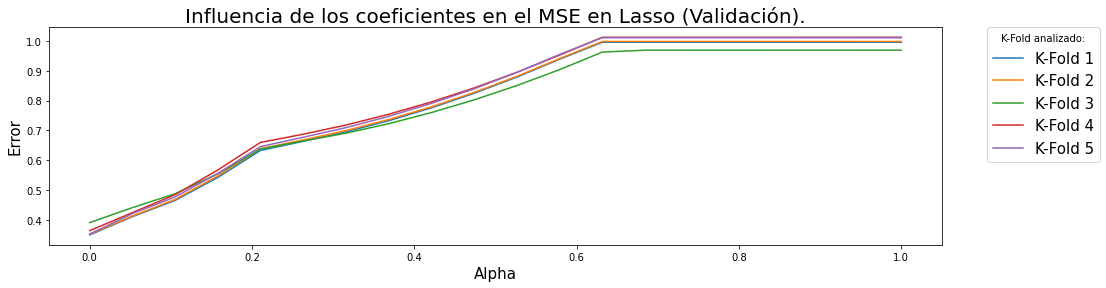

In [28]:
space = np.linspace(0.0001,1,20) 

kf = KFold(n_splits=5, shuffle=True, random_state=2)

MSE = []
for l in space:
    model = Lasso(alpha = l)
    mse = []
    for t,v in kf.split(x_val):
        x_t, x_v = x_train.loc[t], x_train.loc[v]
        y_t, y_v = y_train.loc[t], y_train.loc[v]
        model.fit(x_t,y_t)
        y_pred = model.predict(x_v)
        mse.append(mean_squared_error(y_v,y_pred))
    MSE.append(mse)
    
ind = 1
for y_arr in np.squeeze(MSE).T:
    plt.plot(space, y_arr, label='K-Fold '+str(ind))
    plt.legend(title='K-Fold analizado:', bbox_to_anchor=(1.05, 1)
               , loc='upper left', borderaxespad=0., prop={'size': 15})
    plt.xlabel('Alpha', fontsize = 15)
    plt.ylabel('Error', fontsize = 15)
    plt.title('Influencia de los coeficientes en el MSE en Lasso (Validación).', fontsize = 20)
    ind+=1  

Comparando el set de entrenamiento, es posible notar como la forma lineal tiene un MSE de 0.357 aprox. lo cual es menor que en cualquier caso de alfa.

Un caso similar ocurre en el set de validación, dado que el error lineal es de 0.36 aprox, lo cual es menor que para cualquier valor de alfa, en cualquiera de sos K-Folds.

En cuanto al sobreajuste, se puede mencionar, que dado que el set de validación presenta más discrepancias que el de entrenamiento, entre sus k-folds, es muy probable que exista un sobreajuste en el entrenamiento.

#### 2.g _Grid search_ para SVM

Para terminar, comparemos el desempeño de los métodos lineales con un método no lineal, las SVM. Para esto buscaremos ajustar los hiperparámetros más relevantes del modelo, en este caso el parámetro C y epsilon, la penalización y el margen de holgura. Comente sobre la significancia de estos parámetros y su influencia sobre la máquina. Luego realice una búsqueda en un mallado de estos parámetros, evaluando el score (coeficiente de determinación) o MSE o ambos.

Nota: Entrenar una SVM toma mucho más tiempo que las regresiones lineales, por lo cual es recomendable probar primero su código en un número reducido de puntos y luego entrenar todos los modelos asegurandose de guardar bien los resultados. Si su máquina es muy lenta es incluso recomendable que esta parte la realice en Collab de Google si desea explorar un número relevante de puntos. El mallado propuesto en el código es de referencia y puede elegirlo o construirlo como usted estime más conveniente.

De todos los modelos entrenados, ¿Cuál es el mejor? ¿Cómo se compara el desempeño de este modelo con el mejor modelo lineal encontrado por usted? Adjunte gráficos que le parezcan relevantes.

In [29]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [30]:
# Establecemos un grid con los valores de coste que queremos evaluar
C = [0.001, 0.01, 0.1, 0.3, 0.5, 1, 2, 3, 4, 5, 7, 10]
epsilon = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

grid_hiperparametros = {'C': C, 'epsilon':epsilon} 

svr = svm.SVR(max_iter=10)

# Definimos la busqueda mediante 10-fold CV
busqueda_grid = GridSearchCV(estimator = svm.SVR(), 
                             param_grid = grid_hiperparametros,
                            scoring = 'neg_mean_squared_error',
                            refit = 'neg_mean_squared_error',
                            verbose = 2,
                            cv = 2, #kFolds
                            n_jobs = 1) 

#x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).ravel()

# Aplicamos la busqueda
busqueda_grid.fit(x_train[:1000], y_train[:1000]) #Agrandar la data en caso de querer probar de mejor manera el sistema

Fitting 2 folds for each of 132 candidates, totalling 264 fits
[CV] C=0.001, epsilon=0.01 ...........................................
[CV] ............................ C=0.001, epsilon=0.01, total=   0.0s
[CV] C=0.001, epsilon=0.01 ...........................................
[CV] ............................ C=0.001, epsilon=0.01, total=   0.1s
[CV] C=0.001, epsilon=0.1 ............................................
[CV] ............................. C=0.001, epsilon=0.1, total=   0.0s
[CV] C=0.001, epsilon=0.1 ............................................
[CV] ............................. C=0.001, epsilon=0.1, total=   0.0s
[CV] C=0.001, epsilon=0.2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. C=0.001, epsilon=0.2, total=   0.0s
[CV] C=0.001, epsilon=0.2 ............................................
[CV] ............................. C=0.001, epsilon=0.2, total=   0.0s
[CV] C=0.001, epsilon=0.3 ............................................
[CV] ............................. C=0.001, epsilon=0.3, total=   0.0s
[CV] C=0.001, epsilon=0.3 ............................................
[CV] ............................. C=0.001, epsilon=0.3, total=   0.0s
[CV] C=0.001, epsilon=0.4 ............................................
[CV] ............................. C=0.001, epsilon=0.4, total=   0.0s
[CV] C=0.001, epsilon=0.4 ............................................
[CV] ............................. C=0.001, epsilon=0.4, total=   0.0s
[CV] C=0.001, epsilon=0.5 ............................................
[CV] ............................. C=0.001, epsilon=0.5, total=   0.0s
[CV] C=0.001, epsilon=0.5 ............................................
[CV] .

[CV] ............................... C=0.1, epsilon=0.9, total=   0.0s
[CV] C=0.1, epsilon=1 ................................................
[CV] ................................. C=0.1, epsilon=1, total=   0.0s
[CV] C=0.1, epsilon=1 ................................................
[CV] ................................. C=0.1, epsilon=1, total=   0.0s
[CV] C=0.3, epsilon=0.01 .............................................
[CV] .............................. C=0.3, epsilon=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.01 .............................................
[CV] .............................. C=0.3, epsilon=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.1 ..............................................
[CV] ............................... C=0.3, epsilon=0.1, total=   0.0s
[CV] C=0.3, epsilon=0.1 ..............................................
[CV] ............................... C=0.3, epsilon=0.1, total=   0.0s
[CV] C=0.3, epsilon=0.2 ..............................................
[CV] .

[CV] ................................. C=1, epsilon=0.8, total=   0.0s
[CV] C=1, epsilon=0.8 ................................................
[CV] ................................. C=1, epsilon=0.8, total=   0.0s
[CV] C=1, epsilon=0.9 ................................................
[CV] ................................. C=1, epsilon=0.9, total=   0.0s
[CV] C=1, epsilon=0.9 ................................................
[CV] ................................. C=1, epsilon=0.9, total=   0.0s
[CV] C=1, epsilon=1 ..................................................
[CV] ................................... C=1, epsilon=1, total=   0.0s
[CV] C=1, epsilon=1 ..................................................
[CV] ................................... C=1, epsilon=1, total=   0.0s
[CV] C=2, epsilon=0.01 ...............................................
[CV] ................................ C=2, epsilon=0.01, total=   0.0s
[CV] C=2, epsilon=0.01 ...............................................
[CV] .

[CV] ................................. C=4, epsilon=0.6, total=   0.0s
[CV] C=4, epsilon=0.6 ................................................
[CV] ................................. C=4, epsilon=0.6, total=   0.0s
[CV] C=4, epsilon=0.7 ................................................
[CV] ................................. C=4, epsilon=0.7, total=   0.0s
[CV] C=4, epsilon=0.7 ................................................
[CV] ................................. C=4, epsilon=0.7, total=   0.0s
[CV] C=4, epsilon=0.8 ................................................
[CV] ................................. C=4, epsilon=0.8, total=   0.0s
[CV] C=4, epsilon=0.8 ................................................
[CV] ................................. C=4, epsilon=0.8, total=   0.0s
[CV] C=4, epsilon=0.9 ................................................
[CV] ................................. C=4, epsilon=0.9, total=   0.0s
[CV] C=4, epsilon=0.9 ................................................
[CV] .

[CV] ................................ C=10, epsilon=0.4, total=   0.0s
[CV] C=10, epsilon=0.5 ...............................................
[CV] ................................ C=10, epsilon=0.5, total=   0.0s
[CV] C=10, epsilon=0.5 ...............................................
[CV] ................................ C=10, epsilon=0.5, total=   0.0s
[CV] C=10, epsilon=0.6 ...............................................
[CV] ................................ C=10, epsilon=0.6, total=   0.0s
[CV] C=10, epsilon=0.6 ...............................................
[CV] ................................ C=10, epsilon=0.6, total=   0.0s
[CV] C=10, epsilon=0.7 ...............................................
[CV] ................................ C=10, epsilon=0.7, total=   0.0s
[CV] C=10, epsilon=0.7 ...............................................
[CV] ................................ C=10, epsilon=0.7, total=   0.0s
[CV] C=10, epsilon=0.8 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:    9.2s finished


In [32]:
y_pred_train = busqueda_grid.predict(x_train)
y_pred_val = busqueda_grid.predict(x_val)

print('MSE entrenamiento: ',mean_squared_error(y_train,y_pred_train))
print('MSE validación: ',mean_squared_error(y_val,y_pred_val))

MSE entrenamiento:  0.9713642015585402
MSE validación:  0.9740911302044555


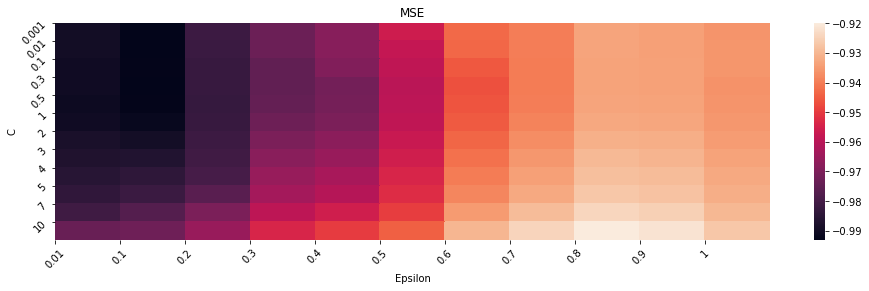

In [33]:
import seaborn as sns

scores = busqueda_grid.cv_results_['mean_test_score'].reshape(12,11)

ax = sns.heatmap(scores)
plt.xticks(np.arange(11),epsilon, rotation = 45)
plt.yticks(np.arange(12),C, rotation = 45)
plt.xlabel("Epsilon")
plt.ylabel("C")
plt.title("MSE")
plt.show()

In [34]:
print("Los mejores parámetros son %s con score de %0.2f" % (busqueda_grid.best_params_, busqueda_grid.best_score_))

Los mejores parámetros son {'C': 10, 'epsilon': 0.8} con score de -0.92


Respecto a los valores a encontrar, C afecta en la holgura que presentará el modelo, mientras que el epsilon controla la penalización de los datos. Y en efecto, cuando se penalizan más los datos, y existe una mayor holgura pareciese que el score sube. Claro que hay que mencionar, que sólo se está trabajando con una porcion reducida de los datos, por lo que esto no se puede asegurar.

En cuanto a la mejor métrica, pareciese ser la lineal, aunque es necesario probar la SVM con un numero mayor de datos. Esto dado que en el caso de Lasso y Ridge, ambas tubieron mayor error que la lineal. Y de igual forma, la SVM da valores negativos, lo que significa que no está aprendiendo nada.